In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
import random


import os, sys
sys.path.insert(0,'..')

from collections import deque 

from dfibert.tracker.nn.rl import Agent, DQN
import dfibert.envs.RLtractEnvironment as RLTe
from dfibert.cache import save_vtk_streamlines
from dfibert.envs._state import TractographyState
from tqdm import trange
from dfibert.data import ISMRMDataContainer 
from dipy.tracking import utils
import dipy.reconst.dti as dti

import matplotlib.pyplot as plt
%matplotlib notebook

#from train import load_model

# Environment

In [2]:
env = RLTe.RLtractEnvironment(stepWidth=0.8, action_space=100, dataset = '100307', device = 'cpu', seeds = None, tracking_in_RAS = False, odf_state = False)

Loading dataset #  100307
sphere_odf = sphere_action = repulsion100
Computing ODF


In [ ]:
env._init_shmcoeff()

# Tracking
## Analysis of tracking on subset of streamlines
The next cell carries out a ground-truth tracking workflow.

In [ ]:
streamlines = []
for i in trange(100):
    terminal = False
    all_states = []
    state = env.reset(seed_index=i)
    current_direction = None
    all_states.append(state.getCoordinate().numpy())
    terminal = False
    while not terminal:
        my_position = state.getCoordinate().double().squeeze(0)
        action = env._get_best_action(current_direction, my_position)
        current_direction = env.directions[action].numpy()
        state, reward, terminal, _  = env.step(action.reshape(-1,1))
        all_states.append(state.getCoordinate().squeeze(0).numpy())

    state = env.reset(seed_index=i, terminal_F=True)
    current_direction = None
    terminal = False
    all_states = all_states[::-1]
    while not terminal:
        my_position = state.getCoordinate().double().squeeze(0)
        action = env._get_best_action(current_direction, my_position)
        current_direction = env.directions[action].numpy()
        #action = gt_actions[i]
        state, reward, terminal, _  = env.step(action.reshape(-1,1), direction="backward")
        if False in torch.eq(state.getCoordinate().squeeze(0), my_position):
            all_states.append(state.getCoordinate().squeeze(0).numpy())
            
    streamlines.append(np.asarray(all_states))

## Visualize our streamlines

<IPython.core.display.Javascript object>


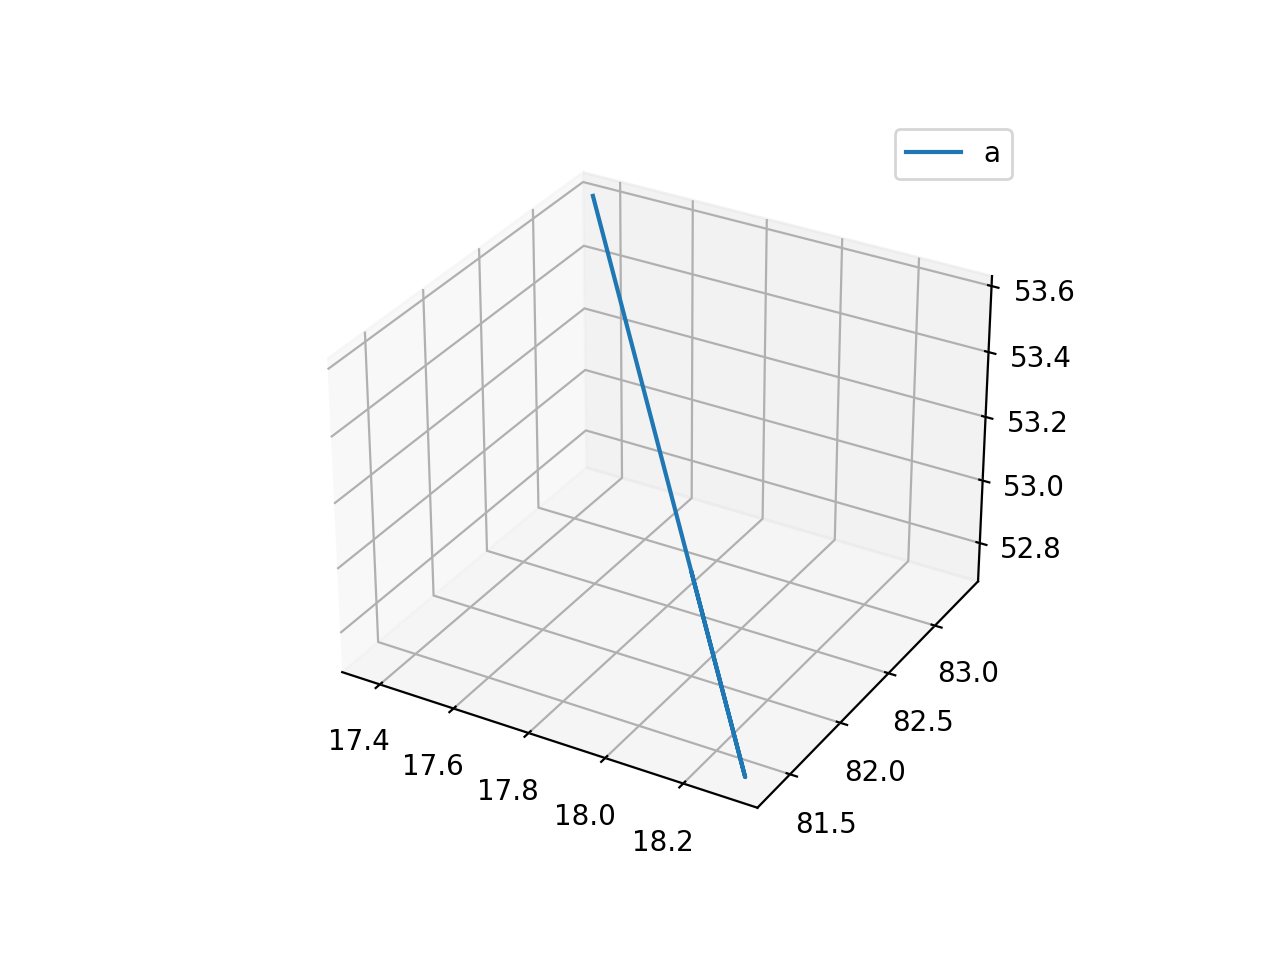

In [7]:
%matplotlib notebook
streamline_index = 9
streamline_np = np.stack(streamlines[streamline_index])

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(streamline_np[:,0], streamline_np[:,1], streamline_np[:,2])
#plt.legend(['gt', 'agent'])
plt.legend('agent')

## Evaluation on ISMRM data
The next cell conducts tracking on ISMRM evaluation data.

In [8]:
dataset = ISMRMDataContainer()

dti_model = dti.TensorModel(dataset.data.gtab, fit_method='LS')
dti_fit = dti_model.fit(dataset.data.dwi, mask=dataset.data.binarymask)
fa_img = dti_fit.fa

seed_mask = fa_img.copy()
seed_mask[seed_mask >= 0.2] = 1
seed_mask[seed_mask < 0.2] = 0

seeds = utils.seeds_from_mask(seed_mask, affine=np.eye(4), density=1) # tracking in IJK

DataContainerNotLoadableError: The File 'data/ISMRM2015/Diffusion.bvals' can't be retrieved from folder 'data/ISMRM2015' for the dataset.

In [ ]:
env = RLTe.RLtractEnvironment(stepWidth=0.8, action_space=100, device = 'cpu', seeds = torch.FloatTensor(seeds), tracking_in_RAS = False, odf_state = False)
env.dataset = dataset
env.dataset.generate_fa()
env._init_odf()
env.reset(seed_index=0)

In [ ]:
streamlines = []
for i in trange(len(seeds)):
    terminal = False
    all_states = []
    state = env.reset(seed_index=i)
    current_direction = None
    all_states.append(state.getCoordinate().numpy())
    terminal = False
    while not terminal:
        my_position = state.getCoordinate().double().squeeze(0)
        #print(action)
        action = env._get_best_action(current_direction, my_position)
        current_direction = env.directions[action].numpy()
        #action = gt_actions[i]
        state, reward, terminal, _  = env.step(action)
        all_states.append(state.getCoordinate().squeeze(0).numpy())

    state = env.reset(seed_index=i, terminal_F=True)
    #print(env.seed_index)
    current_direction = None
    terminal = False
    all_states = all_states[::-1]
    while not terminal:
        my_position = state.getCoordinate().double().squeeze(0)
        action = env._get_best_action(current_direction, my_position)
        current_direction = env.directions[action].numpy()
        #action = gt_actions[i]
        state, reward, terminal, _  = env.step(action, direction="backward")
        if False in torch.eq(state.getCoordinate().squeeze(0), my_position):
            all_states.append(state.getCoordinate().squeeze(0).numpy())
            
    streamlines.append(np.asarray(all_states))

In [ ]:
%matplotlib notebook
streamline_index = 0
streamline_np = np.stack(streamlines[streamline_index])

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(streamline_np[:,0], streamline_np[:,1], streamline_np[:,2])
#plt.legend(['gt', 'agent'])
plt.legend('agent')

# Reinforcement Learning
## DQN

WIP code !!! Here by dragons :) 

In [ ]:
streamline_index = 0
device = "cpu"
max_steps = 30000000
replay_memory_size = 100000
agent_history_length = 1
evaluate_every = 200000
eval_runs = 5#20
network_update_every = 10000
start_learning = 10000
eps_annealing_steps = 400000

max_episode_length = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 512
learning_rate = 0.000001 


state = env.reset(seed_index=streamline_index)
env.referenceStreamline_ijk, state.getCoordinate()

In [ ]:
agent = Agent(n_actions=20, inp_size=state.getValue().shape, device=device, hidden=10, gamma=0.99, 
              agent_history_length=agent_history_length, 
              memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

Training loop is run in the next cells

In [ ]:
eval_rewards = []
all_distances = []
all_states = []
l2s = []
max_episode_length = 15
fa_threshold = 0.1
K = 3

#agent.main_dqn.eval()
for _ in range(1):
    eval_steps = 0
    state = env.reset(seed_index=streamline_index)
    next_state = state
    all_states.append(state.getCoordinate())
    eval_episode_reward = 0
    episode_final = 0
    while eval_steps < max_episode_length:
        
        with torch.no_grad():
            state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
            action = torch.argmax(agent.main_dqn(state_v)).item()
        
        my_position = all_states[-1]
        current_direction = None
        
        if(eval_steps > 0):
            # compute tangent of previous step
            current_direction = all_states[-1] - all_states[-2]
            current_direction = current_direction / torch.sqrt(torch.sum(current_direction**2))
            current_direction = current_direction.view(1,3)
        
        #action = get_multi_best_action(current_direction, odf_interpolator, my_position, mysphere, sphere_verts_torch, K = K)
        action = env._get_best_action(current_direction, my_position)

        
        next_state, reward, terminal, _ = env.step(action)
        
        #reward = reward
        
        print(eval_steps, my_position, "=>", next_state.getCoordinate().numpy(), action, reward)

        
        all_distances.append(reward)
        all_states.append(next_state.getCoordinate().squeeze())
                
        state = next_state
        print("---")
        if terminal:
            terminal = False
            break
            
        eval_episode_reward += reward.squeeze()
        eval_steps += 1

    eval_rewards.append(eval_episode_reward)

print("Evaluation score:", np.min(eval_rewards))